# 1. Convert Sentinel-2 Grid KML to Geoparquet

The official Sentinel-2 grid is sourced from this ~100MB KML file:
https://sentinel.esa.int/documents/247904/1955685/S2A_OPER_GIP_TILPAR_MPC__20151209T095117_V20150622T000000_21000101T000000_B00.kml 

The following notebook converts this file to the cloud-native file format [GeoParquet](https://github.com/opengeospatial/geoparquet) for easier visualization and batch processing of other datasets.

In [1]:
import geopandas as gpd
import dask_geopandas
from shapely import wkt
import utils
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load KML file directly from URL
gdf = gpd.read_file(utils.URL_ESA_S2_GRID_KML, 
                    engine="pyogrio", force_2d=True, 
                    columns=["Name", "description", "geometry"])
gdf.rename(columns=dict(Name='tile'), inplace=True)
gdf.head()

tile                                        description  \
0  01CCV  TILE PROPERTIES<br><table border=0 cellpadding...   
1  01CDH  TILE PROPERTIES<br><table border=0 cellpadding...   
2  01CDJ  TILE PROPERTIES<br><table border=0 cellpadding...   
3  01CDK  TILE PROPERTIES<br><table border=0 cellpadding...   
4  01CDL  TILE PROPERTIES<br><table border=0 cellpadding...   

                                            geometry  
0  GEOMETRYCOLLECTION (POLYGON ((180.00000 -73.05...  
1  GEOMETRYCOLLECTION (POLYGON ((180.00000 -83.80...  
2  GEOMETRYCOLLECTION (POLYGON ((180.00000 -82.91...  
3  GEOMETRYCOLLECTION (POLYGON ((180.00000 -82.01...  
4  GEOMETRYCOLLECTION (POLYGON ((180.00000 -81.12...

In [3]:
# GEOMETRYCOLLECTION contains polygon and centroid. If polygons cross antimeridian split into 2
# Assume first geometry is main footprint polygon:
gdf['geometry'] = gdf.geometry.apply(lambda x: x.geoms[0])

# Extract UTM_WKT and EPSG from "Description" column
gdf['epsg'] = gdf.apply(utils.get_epsg, axis=1)
gdf['utm_wkt'] = gdf.apply(utils.get_utm_wkt, axis=1)

# Drop description column 
gdf = gdf.drop(columns=['description'])
gdf.head()

tile                                           geometry   epsg  \
0  01CCV  POLYGON ((180.00000 -73.05974, 176.86462 -72.9...  32701   
1  01CDH  POLYGON ((180.00000 -83.80855, 174.71288 -83.7...  32701   
2  01CDJ  POLYGON ((180.00000 -82.91344, 175.74819 -82.8...  32701   
3  01CDK  POLYGON ((180.00000 -82.01866, 176.55270 -81.9...  32701   
4  01CDL  POLYGON ((180.00000 -81.12317, 177.19616 -81.1...  32701   

                                             utm_wkt  
0  POLYGON ((300000 2000020,300000 1890220,409800...  
1  POLYGON ((399960 800020,399960 690220,509760 6...  
2  POLYGON ((399960 900040,399960 790240,509760 7...  
3  POLYGON ((399960 1000000,399960 890200,509760 ...  
4  POLYGON ((399960 1100020,399960 990220,509760 ...

In [4]:
# Add simple UTM bounds (left, down, right, up)
gdf['utm_bounds'] = gdf.utm_wkt.apply(lambda x: wkt.loads(x).bounds).astype(str)

In [5]:
print(f"Number of tiles: {len(gdf)}")
gdf.to_parquet("sentinel-2-grid.parquet")

Number of tiles: 56686


## 1.1 Only keep tiles that intersect with land areas

<Axes: >

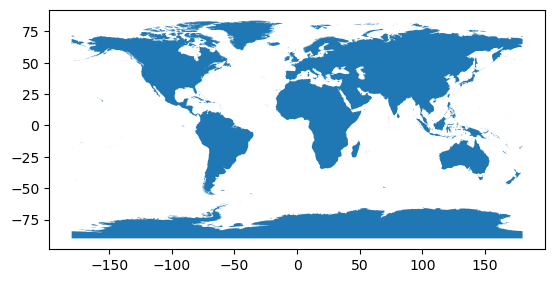

In [9]:
# Load high resolution land mask
land_highres = gpd.read_file(utils.URL_NE_VEC_10m_LAND_GEOJSON, engine="pyogrio")
land_highres.plot()

In [10]:
%%time 
# Load as dask-geopandas dataframe and intersect with land mask
ddf = dask_geopandas.from_geopandas(gdf, npartitions=4)
ind_land = ddf.intersects(land_highres.unary_union).compute()
gdf_land = gdf[ind_land].reset_index(drop=True)

# Add simple UTM bounds (left, down, right, up)
gdf_land['utm_bounds'] = gdf_land.utm_wkt.apply(lambda x: wkt.loads(x).bounds).astype(str)
gdf_land.head()

CPU times: user 7min 39s, sys: 3min 31s, total: 11min 10s
Wall time: 2min 32s


tile                                           geometry   epsg  \
0  01CEH  POLYGON ((-177.00144 -82.85238, -169.14642 -82...  32701   
1  01CEJ  POLYGON ((-177.00128 -81.95638, -170.00719 -81...  32701   
2  01FBE  POLYGON ((180.00000 -50.59941, 178.76332 -50.5...  32701   
3  01FBF  POLYGON ((180.00000 -49.70001, 178.84184 -49.6...  32701   
4  01GBH  POLYGON ((180.00000 -47.89995, 178.98771 -47.8...  32701   

                                             utm_wkt  \
0  POLYGON ((499980 800020,499980 690220,609780 6...   
1  POLYGON ((499980 900040,499980 790240,609780 7...   
2  POLYGON ((199980 4500040,199980 4390240,309780...   
3  POLYGON ((199980 4600000,199980 4490200,309780...   
4  POLYGON ((199980 4800040,199980 4690240,309780...   

                                   utm_bounds  
0    (499980.0, 690220.0, 609780.0, 800020.0)  
1    (499980.0, 790240.0, 609780.0, 900040.0)  
2  (199980.0, 4390240.0, 309780.0, 4500040.0)  
3  (199980.0, 4490200.0, 309780.0, 4600000.0)  
4  (199980.0, 4690240.0, 309780.0, 4800040.0)

In [12]:
print(f"Number of tiles: {len(gdf_land)}")
gdf_land.to_parquet("sentinel-2-grid_LAND.parquet")

Number of tiles: 20430
